# Instancia de librarias

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from datetime import datetime # Trabajar con fechas

# Metricas de desempeño de modelos 
import scipy.stats as stats
import statistics
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# Series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
import pmdarima as pm # autoarima
# import statsmodels.formula.api as smf

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# Tamaño del cuadro de las gráficas por defult
plt.rcParams["figure.figsize"] = (12,6)

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


print("Setup complete")

Setup complete


# Importación de datos

In [3]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [4]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
wall_data.info()
wall_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11


#### Frecuencia de tiempo

In [5]:
stores = wall_data
stores = stores.iloc[:,[1,0,2]]

# Periodos de tiempo
# stores.Date = pd.PeriodIndex(stores.Date, freq='Y')
# stores.Date = pd.PeriodIndex(stores.Date, freq='M')
# stores.Date = pd.PeriodIndex(stores.Date, freq='d')
# stores.Date = pd.PeriodIndex(stores.Date, freq='q')

stores.Date = pd.PeriodIndex(stores.Date, freq='w')
# ValueError: offset must be a timedelta strictly between -timedelta(hours=24) and timedelta(hours=24).

# stores = stores.groupby(['Date'])['Weekly_Sales'].aggregate([sum,min,'mean','count']).reset_index()
stores = stores.groupby(['Date','Store'])['Weekly_Sales'].sum().reset_index()
stores['Date'] = stores['Date'].astype(str)
stores['Store'] = stores.Store.astype(str)
stores[['sb','be']] = stores['Date'].str.split(pat='/',expand=True)
stores = stores.iloc[:,[3,1,2]]
stores.columns = ['Date','Store','Weekly_Sales']
stores['Date'] =  stores['Date'] =pd.to_datetime(stores['Date'])
stores.head()



,Date,Store,Weekly_Sales
0,2010-02-01,1,"1,643,690.90"
1,2010-02-01,2,"2,136,989.46"
2,2010-02-01,3,"461,622.22"
3,2010-02-01,4,"2,135,143.87"
4,2010-02-01,5,"317,173.10"


In [6]:
num_store = stores['Store'].unique()
num_store

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'],
      dtype=object)

In [7]:
# for i in num_store:
#     df = stores[stores['store']==i]
#     print(frame)
semana = {}
for store in num_store:
    df = stores[stores['Store']==store].copy()
    df.drop('Store',axis=1, inplace=True)
    semana[store] = df
    df.set_index('Date',inplace=True)

# Elegir una tienda    
# semana['20']

In [8]:
# semana['20']

#### Performance

In [9]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    

In [10]:
def cross_validation(model,a,b):
    cv = cross_val_score(model,a,b,cv=10,scoring='r2')
    print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [11]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

#### Diferencias

In [12]:
def dif(st):
    prev_values = st.Weekly_Sales.shift()
    dif = st.Weekly_Sales - prev_values
    dif.plot()

#### Estacionalidad

In [13]:
def estacionalidad(st):
    est = seasonal_decompose(st.iloc[1:],model='additive',period = 52)
    est.plot();

#### Conjunto de entrenamiento y test

In [14]:
def tra_tes(st):
    # train = st.Weekly_Sales[:len(st.Weekly_Sales)-48]  # primero datos
    # test = st.Weekly_Sales[len(st.Weekly_Sales)-48:]   # últimos datos
    
    # ------------------------------- TODO ------------------------#
    train = st.Weekly_Sales[:-48]  # primero datos
    test = st.Weekly_Sales[-48:]  # primero datos,  una mas
    # Prueba ---!!!!!
    # En las prediciones que haga 49
    # ------------------------------- TODO ------------------------#
    return train,test

In [15]:
# semana['20'].head()

## Semanal

In [16]:
s_20 =  semana['20'].rename_axis(index=None,columns=None)
s_14 =  semana['14'].rename_axis(index=None,columns=None) # No son datos estacionarios
s_5 =  semana['5'].rename_axis(index=None,columns=None)

## Elegit tienda

<AxesSubplot:>

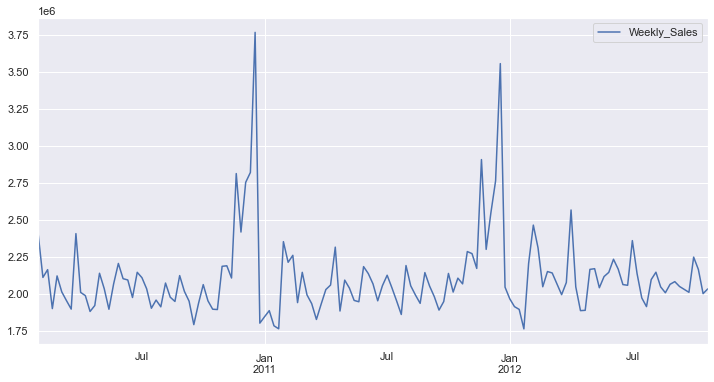

In [17]:
s_20.plot()

#### Prueba  Dickey Fuller Aumentada (ADF)

In [18]:
adf(s_20.Weekly_Sales,'Weekly_Sales')

Resultados ADF: ,Weekly_Sales
Test Statistic           -5.39
p-value                   0.00
No Lags Used              4.00
Observation number      138.00
Critical Values (1%)     -3.48
Critical Values (5%)     -2.88
Critical Values (10%)    -2.58
dtype: float64
Los datos son estacionarios


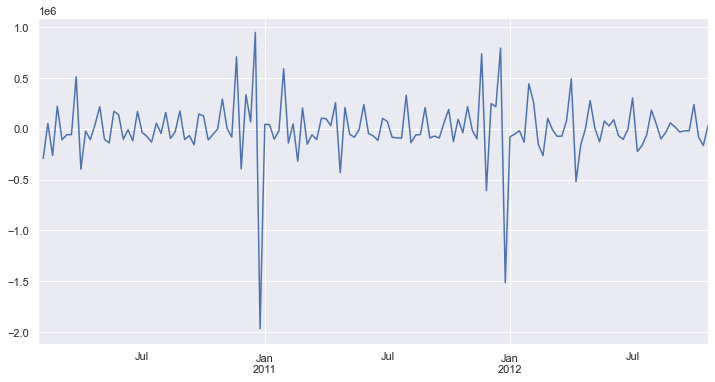

In [19]:
# prev_values = s_20.Weekly_Sales.shift()
# dif = s_20.Weekly_Sales - prev_values
# dif.plot()
dif(s_20)

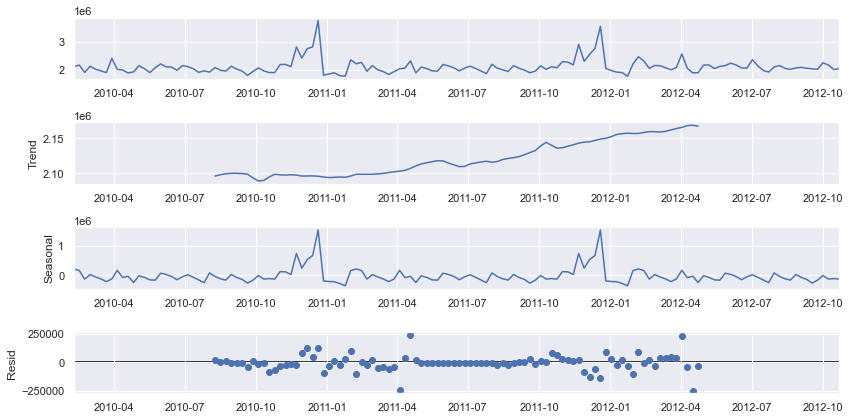

In [20]:
# differenced_store_20_dif = seasonal_decompose(s_20.iloc[1:],model='additive',period = 52)
# differenced_store_20_dif.plot();
estacionalidad(s_20)

### ARIMA

<AxesSubplot:>

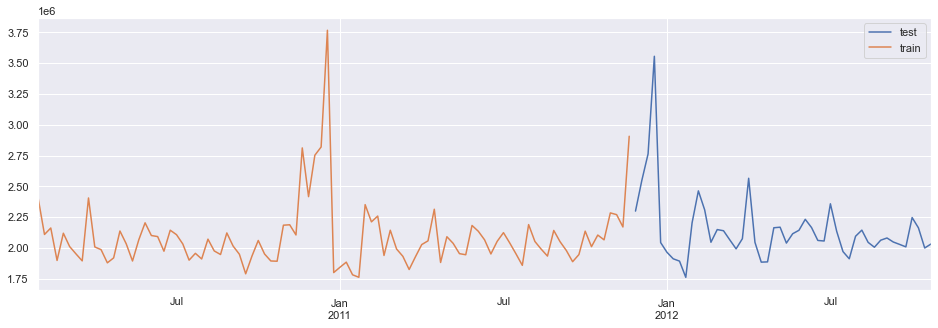

In [21]:
# train = s_20.Weekly_Sales[:len(s_20.Weekly_Sales)-48]  # primero datos
# test = s_20.Weekly_Sales[len(s_20.Weekly_Sales)-48:]   # últimos datos 

train, test = tra_tes(s_20)
test.plot(figsize=(16,5),legend=True, label='test')
train.plot(legend=True, label='train')


In [22]:
# Para determinar el train y el test, se sugiere que los datos asignados sean del 80% y 20% sucesivamente
# pero a mayor número de datos de entrenamiento, el AIC disminuye y el R2 aumenta
# caso contrario, el AIC aumenta y el R2 se hace negativo
# ¿De qué depende el periodo que se quiere calcular? Por ejemplo, yo determine 48 semanas que se quieren predecir
print(len(train),len(test))

95 48


In [23]:
# Nunca se debe utilizar toda la información de un dataset, debe ser el dataset de train 
# para el entrenamiento de los modelo.
# El test nunca filtra inforamción al train.

# D:parametro parte estacional, d:parametro parte no estacional
arima_model = pm.auto_arima(train, start_p=0,d=0,start_q=0,max_p=5,max_d=5,max_q=5,
                            start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=52,
                            seasonal=True,error_Action='warn',trace=True,test='adf',
                            supress_warnings = True, stepwise=True, random_state=20,
                            n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1135.241, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1139.189, Time=0.92 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1139.307, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1153.186, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1137.210, Time=0.86 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1137.210, Time=0.38 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=6.28 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1137.192, Time=0.21 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1137.314, Time=0.33 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1139.263, Time=0.65 sec

Best model:  ARIMA(0,0,0)(0,1,0)[52] intercept
Total fit time: 10.569 seconds


#### SARIMAX

In [24]:
arima_model = SARIMAX(train,order=(0,0,0),seasonal_order = (0,1,0,52))     #AIC 1,153.186; D=1;d=0  /// tienda 20
# arima_model = SARIMAX(train,order=(2,0,1),seasonal_order = (1,0,0,52))        # AIC 2,661.550 #d=0,D=0  /// no estacionario tienda 14
# arima_model = SARIMAX(train,order=(0,1,1),seasonal_order = (1,0,0,52))        # AIC 2,630.246 #d=1,D=0  /// no estacionario tienda 14
arima_result = arima_model.fit() 
arima_result.summary()

C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\Users\Rodrigo Piña\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:             Weekly_Sales   No. Observations:                   95
Model:             SARIMAX(0, 1, 0, 52)   Log Likelihood                -575.593
Date:                  Thu, 08 Dec 2022   AIC                           1153.186
Time:                          14:21:45   BIC                           1154.947
Sample:                      02-01-2010   HQIC                          1153.836
                           - 11-21-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.399e+09   3.66e+08     20.238      0.000    6.68e+09    8.12e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                77.88
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.52
Prob(H) (two-sided):                  0.02   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
arima_result.model_orders
# r2. si no hay una cte (ar,phi_0) en el modelo. este es negativo.
# el autoarima no tiene una cte 

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 0,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 0,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [26]:
arima_pred = arima_result.predict(start= len(train),end=len(s_20)-1,type='levels').rename('ARIMA Predictions')
arima_pred.head(8)

2011-11-28   2,416,051.17
2011-12-05   2,752,122.08
2011-12-12   2,819,193.17
2011-12-19   3,766,687.43
2011-12-26   1,799,737.79
2012-01-02   1,843,030.95
2012-01-09   1,884,345.01
2012-01-16   1,781,805.66
Freq: W-MON, Name: ARIMA Predictions, dtype: float64

In [27]:
# len(arima_pred)
# len(train)
# len(s_20)
# len(test)
# len(train)-len(arima_pred)

<AxesSubplot:>

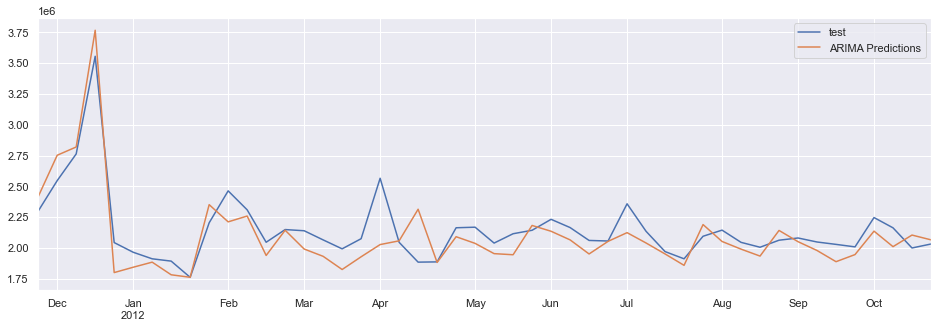

In [28]:
test.plot(figsize=(16,5),legend=True,label='test')
arima_pred.plot(legend=True)

Accuracy test(R2):  69.31876750911997
Mean Absolute Error:  115513.64166666666
Mean Square Error:  23373840437.357723
Root Mean Square Error:  152885.05629183556
Mean Absolute Percentage Error:  0.05279421488588142


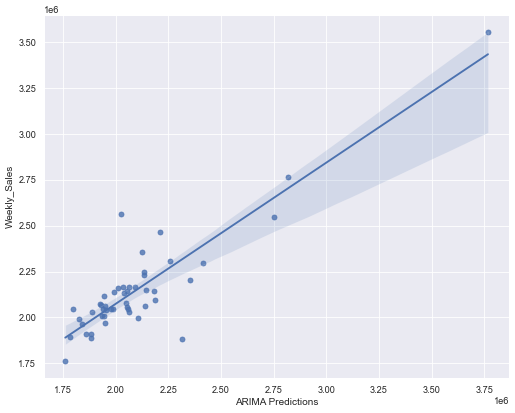

In [29]:
print('Accuracy test(R2): ', metrics.r2_score(test,arima_pred)*100)
performance(test,arima_pred)